In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report, roc_auc_score
from IPython.display import display, HTML
from xgboost import XGBClassifier
from sklearn.utils import class_weight
import os
import xgboost as xgb


In [2]:
# --- 1. Define Keywords ---
GENERAL_DIET_AND_HEALTH_KEYWORDS = {
    'Dietary Restrictions': [
        'vegetarian', 'vegan', 'dairy free foods', 'egg free', 'lactose free',
        'no shell fish', 'free of...'
    ],
    'Health Focus': [
        'low calorie', 'healthy', 'light', 'low cholesterol', 'low protein',
        'very low carbs', 'high fiber', 'high protein', 'protein'
    ]
}

GENERAL_COOKING_AND_EQUIPMENT_KEYWORDS = {
    'Cooking Methods': [
        'no cook', 'stove top', 'oven', 'baking', 'broil/grill', 'microwave',
        'pressure cooker', 'deep fried', 'steam', 'stir fry', 'wok'
    ],
    'Equipment': [
        'small appliance', 'mixer', 'dehydrator', 'refrigerator', 'freezer',
        'bread machine'
    ]
}

GENERAL_MEAL_AND_TIME_KEYWORDS = {
    'Meal Type': [
        'breakfast', 'brunch', 'lunchsnacks', 'one dish meal', 'stew',
        'pot roast', 'meatloaf', 'dessert', 'frozen desserts', 'ice cream',
        'cheesecake', 'bar cookie', 'drop cookies', 'chocolate chip cookies',
        'cake', 'chowders', 'clear soup', 'beef barley soup', 'mushroom soup',
        'pasta shells', 'penne', 'spaghetti', 'macaroni and cheese', 'manicotti',
        'pasta elbow', 'breads', 'quick breads', 'yeast breads',
        'sourdough breads', 'savory pies', 'pie', 'cookie & brownie',
        'beverages', 'punch beverage', 'smoothies', 'shakes', 'sauces',
        'chutneys', 'spreads', 'side dish', 'accompaniment', 'garnish',
        'coleslaw', 'potato salad'
    ],
    'Time & Budget': [
        '< 15 mins', '< 30 mins', '< 60 mins', '< 4 hours', 'weeknight',
        'inexpensive'
    ]
}

GENERAL_INGREDIENT_KEYWORDS = {
    'Proteins & Produce': [
        'chicken', 'beef', 'pork', 'duck', 'goose', 'turkey', 'veal', 'rabbit',
        'lamb/sheep', 'quail', 'deer', 'moose', 'elk', 'pheasant', 'wild game',
        'fish', 'seafood', 'salmon', 'tuna', 'halibut', 'bass', 'catfish',
        'tilapia', 'trout', 'whitefish', 'mahi mahi', 'orange roughy', 'crab',
        'lobster', 'mussels', 'oysters', 'squid', 'octopus', 'crawfish',
        'vegetable', 'soy/tofu', 'tempeh', 'cauliflower', 'artichoke',
        'onions', 'collard greens', 'spinach', 'chard', 'peppers', 'pumpkin',
        'apple', 'strawberry', 'plums', 'pineapple', 'cherries', 'berries',
        'raspberries', 'kiwifruit', 'melons', 'oranges', 'papaya', 'mango',
        'coconut', 'pear', 'lime', 'grapes', 'citrus', 'avocado', 'tropical fruits'
    ],
    'Pantry Staples': [
        'rice', 'brown rice', 'white rice', 'short grain rice',
        'medium grain rice', 'long grain rice', 'oatmeal', 'corn', 'beans',
        'black beans', 'lentil', 'peanut butter', 'cheese', 'yogurt',
        'nuts'
    ]
}

GENERAL_CULTURE_AND_FLAVOR_KEYWORDS = {
    'Regional Cuisine': [
        'chinese', 'japanese', 'thai', 'vietnamese', 'indonesian', 'korean',
        'filipino', 'cambodian', 'malaysian', 'burmese', 'singaporean',
        'laotian', 'pakistani', 'indian', 'bangladeshi', 'nepali', 'sri lankan',
        'southwest asia (middle east)', 'lebanese', 'turkish', 'iraqi',
        'iranian', 'italian', 'greek', 'french', 'german', 'scandinavian',
        'norwegian', 'swedish', 'dutch', 'austrian', 'swiss', 'welsh',
        'finnish', 'polish', 'portuguese', 'russian', 'hungarian', 'czech',
        'georgian', 'spanish', 'moroccan', 'nigerian', 'egyptian',
        'ethiopian', 'south african', 'sudanese', 'somalian', 'ghanaian',
        'kenyan', 'tanzanian', 'southern u.s.', 'southwestern u.s.',
        'native american', 'puerto rican', 'cuban', 'caribbean', 'creole',
        'cajun', 'tex mex', 'brazilian', 'argentinian', 'chilean', 'peruvian',
        'colombian', 'ecuadorean', 'venezuelan', 'guatemalan', 'costarican',
        'mexican', 'honduran', 'nicaraguan', 'salvadoran', 'panamanian',
        'bolivian', 'paraguayan', 'uruguayan', 'australian', 'new zealand',
        'polynesian', 'fijian', 'samoan', 'canadian', 'icelandic'
    ],
    'Flavor & Occasion': [
        'spicy', 'hot chili', 'cayenne', 'peppery', 'fiery', 'umami', 'savory',
        'rich', 'meaty', 'miso', 'sweet', 'sugary', 'honeyed', 'sour', 'tangy',
        'citrusy', 'vinegary', 'bitter', 'salty', 'briny', 'soy sauce',
        'christmas', 'thanksgiving', 'halloween', "st. patrick's day",
        'ramadan', 'hanukkah', 'labor day', 'memorial day', 'birthday', 'easter',
        'new year', 'spring', 'summer', 'winter', 'fall', 'potluck',
        'for large groups', 'camping', 'college food', 'beginner cook'
    ]
}

In [6]:
df = pd.read_csv('C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/Capstone/Capstone_Akmal_Andri_Zahran/recipes_new.csv')

In [8]:
# Tampilkan semua kolom
pd.set_option('display.max_columns', None)  # Tidak ada batas jumlah kolom
pd.set_option('display.expand_frame_repr', False)  # Tampilkan dalam 1 baris (jika memungkinkan)
df = pd.read_csv("C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/Capstone/Capstone_Akmal_Andri_Zahran/recipes_new.csv")
df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1440,45,1485,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,https://img.sndimg.com/food/image/upload/w_555...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","4, 1/4, 1, 1","blueberries, granulated sugar, vanilla yogurt,...",4.5,4.0,171,2,1,8,30,37,4,30,3,4.0,"Toss 2 cups berries with sugar., Let stand for..."
1,45,Buttermilk Pie With Gingersnap Crumb Crust,1580,tristitia,50,30,80,1999-08-06T00:40:00Z,Make and share this Buttermilk Pie With Ginger...,https://img.sndimg.com/food/image/upload/w_555...,Pie,"Dessert, Healthy, Weeknight, Oven, < 4 Hours","3/4, 1, 1, 2, 3, 1/4, 1, 1/2, 1/2, 2","sugar, margarine, egg, flour, salt, buttermilk...",4.0,3.0,228,7,2,24,282,38,0,25,4,8.0,"Preheat oven to 350°F., Make pie crust, using ..."
2,49,Chicken Breasts Lombardi,174711,Queen Dragon Mom,30,45,75,1999-08-14T19:58:00Z,Make and share this Chicken Breasts Lombardi r...,https://img.sndimg.com/food/image/upload/w_555...,Chicken Breast,"Chicken, Poultry, Meat, European, Very Low Car...","2, 2, 12, 1/2, 1/3, 3/4, 1/2, 1/2, 1/2, 1/2, 1/4","fresh mushrooms, butter, boneless skinless chi...",5.0,21.0,628,25,13,203,849,14,1,2,58,6.0,Cook mushrooms in 2 tbsp butter in a large sk...
3,56,Buttermilk Pie,1581,thefensk,60,20,80,1999-08-30T10:02:00Z,This recipe was originally noted by my wife on...,https://img.sndimg.com/food/image/upload/w_555...,Pie,"Dessert, Oven, < 4 Hours, Easy","1/2, 1 1/2, 3, 3, 1, 1, 1, 1","butter, margarine, sugar, flour, eggs, salt, v...",5.0,171.0,396,19,10,102,270,52,1,40,5,8.0,"Preheat oven to 400°F., Beat the butter and su..."
4,58,Low-Fat Burgundy Beef & Vegetable Stew,1533,Dancer,134,30,164,1999-08-14T19:48:00Z,Make and share this Low-Fat Burgundy Beef & Ve...,https://img.sndimg.com/food/image/upload/w_555...,Stew,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...","1 1/2, 1, 1, 1/2, 1/2, 1, 1/2, 3, 5 1/2, 1, 2, 1","beef eye round, dried thyme leaves, salt, pepp...",4.5,7.0,280,6,2,67,592,22,6,9,30,6.0,"Trim fat from beef, cut into 1-inch pieces., I..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    52785 non-null  int64  
 1   Name                        52785 non-null  object 
 2   AuthorId                    52785 non-null  int64  
 3   AuthorName                  52785 non-null  object 
 4   CookTime                    52785 non-null  int64  
 5   PrepTime                    52785 non-null  int64  
 6   TotalTime                   52785 non-null  int64  
 7   DatePublished               52785 non-null  object 
 8   Description                 52785 non-null  object 
 9   Images                      52785 non-null  object 
 10  RecipeCategory              52785 non-null  object 
 11  Keywords                    52785 non-null  object 
 12  RecipeIngredientQuantities  52785 non-null  object 
 13  RecipeIngredientParts       527

In [3]:
try:
    data = pd.read_csv('C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/Capstone/Capstone_Akmal_Andri_Zahran/recipes_new.csv') # Asumsi ini adalah file dataset Anda
except FileNotFoundError:
    print("Error: 'recipes_new.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Pilih hanya kolom yang ditentukan
columns = [
    'RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime',
    'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent',
    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
    'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Keywords',
    'Images'
]
data = data[columns]

print("Selected Data Head:")
display(data.head())
print("\nSelected Data Info:")
data.info()
print(f"Initial data shape: {data.shape}")

Selected Data Head:


,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,Keywords,Images
0,38,Low-Fat Berry Blue Frozen Dessert,1440,45,1485,"blueberries, granulated sugar, vanilla yogurt,...",171,2,1,8,30,37,4,30,3,4.0,"Dessert, Low Protein, Low Cholesterol, Healthy...",https://img.sndimg.com/food/image/upload/w_555...
1,45,Buttermilk Pie With Gingersnap Crumb Crust,50,30,80,"sugar, margarine, egg, flour, salt, buttermilk...",228,7,2,24,282,38,0,25,4,8.0,"Dessert, Healthy, Weeknight, Oven, < 4 Hours",https://img.sndimg.com/food/image/upload/w_555...
2,49,Chicken Breasts Lombardi,30,45,75,"fresh mushrooms, butter, boneless skinless chi...",628,25,13,203,849,14,1,2,58,6.0,"Chicken, Poultry, Meat, European, Very Low Car...",https://img.sndimg.com/food/image/upload/w_555...
3,56,Buttermilk Pie,60,20,80,"butter, margarine, sugar, flour, eggs, salt, v...",396,19,10,102,270,52,1,40,5,8.0,"Dessert, Oven, < 4 Hours, Easy",https://img.sndimg.com/food/image/upload/w_555...
4,58,Low-Fat Burgundy Beef & Vegetable Stew,134,30,164,"beef eye round, dried thyme leaves, salt, pepp...",280,6,2,67,592,22,6,9,30,6.0,"Vegetable, Meat, Low Cholesterol, Healthy, Fre...",https://img.sndimg.com/food/image/upload/w_555...



Selected Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52785 entries, 0 to 52784
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecipeId               52785 non-null  int64  
 1   Name                   52785 non-null  object 
 2   CookTime               52785 non-null  int64  
 3   PrepTime               52785 non-null  int64  
 4   TotalTime              52785 non-null  int64  
 5   RecipeIngredientParts  52785 non-null  object 
 6   Calories               52785 non-null  int64  
 7   FatContent             52785 non-null  int64  
 8   SaturatedFatContent    52785 non-null  int64  
 9   CholesterolContent     52785 non-null  int64  
 10  SodiumContent          52785 non-null  int64  
 11  CarbohydrateContent    52785 non-null  int64  
 12  FiberContent           52785 non-null  int64  
 13  SugarContent           52785 non-null  int64  
 14  ProteinContent         52785 non-

In [4]:
# --- 3.1. Preprocessing Keywords (sekarang 'tags') ---
# Ganti nama 'Keywords' menjadi 'tags' untuk konsistensi
data.rename(columns={'Keywords': 'tags'}, inplace=True)

# Bersihkan dan proses kolom 'tags' (yang sebelumnya 'Keywords')
data['tags'] = data['tags'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z, ]', '', x))
data['tags'] = data['tags'].apply(lambda x: [tag.strip() for tag in x.lower().split(',') if tag.strip()])

# Terapkan MultiLabelBinarizer untuk membuat fitur biner dari 'tags'
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=data.index)
print(f"Number of unique keywords after binarization: {len(mlb.classes_)}")

# Gabungkan tag biner dengan DataFrame utama
data_processed = pd.concat([data, tags_df], axis=1)

# --- 3.2. Preprocessing Calories dan fitur numerik lainnya ---
# Pastikan 'Calories' adalah numerik dan tangani nilai yang hilang
data_processed.dropna(subset=['Calories'], inplace=True)
data_processed['Calories'] = data_processed['Calories'].astype(int)

# Definisikan bin kalori dan label (dapat diakses secara global untuk fungsi rekomendasi)
bins = [0, 200, 400, 600, 800, 1000, np.inf]
labels = ['0-200', '201-400', '401-600', '601-800', '801-1000', '1000+']
data_processed['calorie_bin'] = pd.cut(data_processed['Calories'], bins=bins, labels=labels, right=True, include_lowest=True)

# Encode calorie_bin menggunakan LabelEncoder
le = LabelEncoder()
data_processed['calorie_bin_encoded'] = le.fit_transform(data_processed['calorie_bin'])
print("Data after Calorie Binning and Encoding:")
display(data_processed[['Name', 'Calories', 'calorie_bin', 'calorie_bin_encoded']].head())
print("Calorie Bins and their Encoded Values:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")

Number of unique keywords after binarization: 267
Data after Calorie Binning and Encoding:


,Name,Calories,calorie_bin,calorie_bin_encoded
0,Low-Fat Berry Blue Frozen Dessert,171,0-200,0
1,Buttermilk Pie With Gingersnap Crumb Crust,228,201-400,2
2,Chicken Breasts Lombardi,628,601-800,4
3,Buttermilk Pie,396,201-400,2
4,Low-Fat Burgundy Beef & Vegetable Stew,280,201-400,2


Calorie Bins and their Encoded Values:
  0-200: 0
  1000+: 1
  201-400: 2
  401-600: 3
  601-800: 4
  801-1000: 5


In [5]:
numerical_features = [
    'CookTime', 'PrepTime', 'TotalTime',
    'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
    'RecipeServings'
]

# Pastikan fitur numerik tidak memiliki NaN sebelum dimasukkan ke model
for col in numerical_features:
    if col in data_processed.columns:
        data_processed[col] = pd.to_numeric(data_processed[col], errors='coerce').fillna(0) # Isi NaN dengan 0

# Kolom tag biner ditambahkan secara dinamis oleh mlb
binarized_tag_features = mlb.classes_.tolist()

# Gabungkan semua fitur untuk X
feature_columns_for_X = numerical_features + binarized_tag_features

# Filter data_processed untuk membuat X
X = data_processed[feature_columns_for_X].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning
y = data_processed['calorie_bin_encoded'].copy() # Gunakan .copy()

# Simpan urutan kolom X yang tepat untuk prediksi di masa mendatang yang konsisten
model_input_feature_columns = X.columns.tolist()
print(f"Features (X) columns for model training: {model_input_feature_columns[:5]}... ({len(model_input_feature_columns)} total)")

# Pembagian data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Features (X) columns for model training: ['CookTime', 'PrepTime', 'TotalTime', 'FatContent', 'SaturatedFatContent']... (279 total)
X_train shape: (42228, 279), y_train shape: (42228,)
X_test shape: (10557, 279), y_test shape: (10557,)


In [6]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weight_dict)

# Inisialisasi XGBClassifier dengan parameter standar
# Parameter 'use_label_encoder' tidak lagi diperlukan di versi XGBoost terbaru
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    n_estimators=100,      # Jumlah pohon (estimators)
    learning_rate=0.1,     # Ukuran langkah (step size)
    max_depth=5,           # Kedalaman maksimum setiap pohon
    subsample=0.8,         # Proporsi sampel yang digunakan untuk setiap pohon
    colsample_bytree=0.8,  # Proporsi fitur yang digunakan untuk setiap pohon
    random_state=42,
    tree_method='hist'     # Gunakan 'hist' untuk kinerja yang lebih cepat
)

# Latih model dengan bobot kelas
print("XGBoost Model Training Complete (using standard parameters).")
xgb_model.fit(X_train, y_train, sample_weight=y_train.map(class_weight_dict))

print("XGBoost Model Training Complete.")


Calculated Class Weights: {0: 0.6534818941504178, 1: 37.04210526315789, 2: 0.3855804525283515, 3: 0.7763927192498621, 4: 2.30527350147396, 5: 7.846153846153846}
XGBoost Model Training Complete (using standard parameters).
XGBoost Model Training Complete.


In [7]:
y_pred = xgb_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       0-200       0.95      0.98      0.97      2692
       1000+       0.77      0.85      0.81        48
     201-400       0.98      0.93      0.95      4563
     401-600       0.90      0.93      0.92      2266
     601-800       0.84      0.90      0.87       764
    801-1000       0.80      0.85      0.82       224

    accuracy                           0.94     10557
   macro avg       0.87      0.91      0.89     10557
weighted avg       0.94      0.94      0.94     10557




Confusion Matrix:


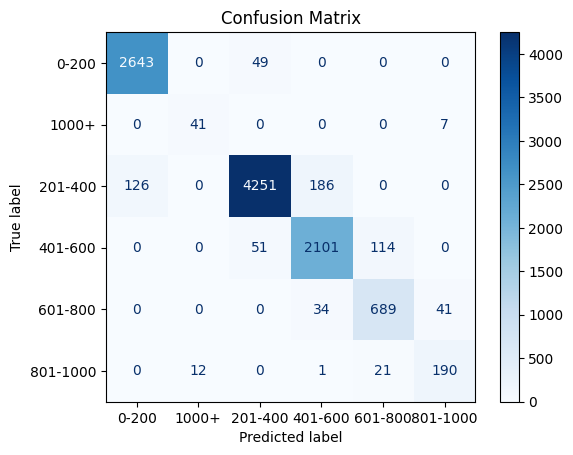

In [8]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [9]:
# ROC AUC Score
try:
    y_pred_proba = xgb_model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted', labels=np.unique(y_test))
    print(f"ROC AUC Score (weighted 'ovr'): {roc_auc:.4f}")
except Exception as e:
    print(f"Could not calculate ROC AUC score: {e}")

ROC AUC Score (weighted 'ovr'): 0.9949


In [10]:
print("\n--- 6. Evaluating Model Performance ---")
y_pred_train = xgb_model.predict(X_train) 
y_pred_test = xgb_model.predict(X_test)   

# Hitung akurasi untuk training dan testing
accuracy_train = (y_train == y_pred_train).mean()
accuracy_test = (y_test == y_pred_test).mean()

print(f"Accuracy on Training Set: {accuracy_train:.4f}")
print(f"Accuracy on Test Set: {accuracy_test:.4f}")

if accuracy_train > accuracy_test * 1.1:
    print("Hasil: POTENSI OVERFITTING! Akurasi training jauh lebih tinggi dari akurasi testing.")
else:
    print("Hasil: Akurasi training dan testing relatif seimbang. Potensi overfitting rendah.")



--- 6. Evaluating Model Performance ---
Accuracy on Training Set: 0.9593
Accuracy on Test Set: 0.9392
Hasil: Akurasi training dan testing relatif seimbang. Potensi overfitting rendah.


In [11]:
# --- 7. Save Model and Preprocessing Objects ---
try:
    # Simpan model dalam format yang kompatibel
    xgb_model.save_model('xgb_model.json')  # Simpan dalam format JSON
    
    with open('mlb.pkl', 'wb') as f:
        pickle.dump(mlb, f)
    with open('le.pkl', 'wb') as f:
        pickle.dump(le, f)
    with open('model_input_feature_columns.pkl', 'wb') as f:
        pickle.dump(model_input_feature_columns, f)
    with open('bins_labels.pkl', 'wb') as f:  # Simpan bins dan labels
        pickle.dump({'bins': bins, 'labels': labels}, f)

    print("Model, preprocessing objects, and bin information saved successfully.")
except Exception as e:
    print(f"Error saving objects: {e}")

Model, preprocessing objects, and bin information saved successfully.


In [40]:
def search_food_by_keywords(df, keywords, target_calories, top_n=5):
    # Pastikan kata kunci adalah huruf kecil untuk pencocokan yang konsisten
    keywords = [k.lower() for k in keywords]

    # --- Langkah 1: Filter DataFrame berdasarkan kata kunci ---
    temp_df = df.copy() 

    # Kolom 'tags' di `data` (dan dengan demikian `temp_df`) sudah berupa daftar string huruf kecil yang dipangkas.
    temp_df['tags_cleaned'] = temp_df['tags'].copy()

    # Filter berdasarkan kata kunci yang disediakan pengguna terhadap tag yang sudah dibersihkan
    filtered_df = temp_df[temp_df['tags_cleaned'].apply(lambda x: any(k in x for k in keywords))].copy()

    if filtered_df.empty:
        print(f"No food found matching keywords: {keywords}")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    # --- Langkah 2: Tentukan bin kalori target untuk prediksi ---
    # Gunakan `bins` dan `labels` yang didefinisikan secara global
    target_calorie_label = None
    # Menentukan label bin yang paling sesuai dengan target_calories
    if target_calories <= bins[0]:
        target_calorie_label = labels[0]
    elif target_calories >= bins[-1]:
        target_calorie_label = labels[-1]
    else:
        for i in range(len(bins) - 1):
            if bins[i] < target_calories <= bins[i+1]:
                target_calorie_label = labels[i]
                break

    try:
        target_calorie_bin_encoded = loaded_le.transform([target_calorie_label])[0]
    except ValueError:
        print(f"Error: Target calorie label '{target_calorie_label}' not found in loaded LabelEncoder classes.")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    # --- Langkah 3: Siapkan fitur untuk prediksi model ---
    # Terapkan kembali MultiLabelBinarizer ke tag *yang sudah dibersihkan* dari filtered_df
    filtered_keywords_encoded = loaded_mlb.transform(filtered_df['tags_cleaned'])
    filtered_keywords_df = pd.DataFrame(filtered_keywords_encoded, columns=loaded_mlb.classes_, index=filtered_df.index)

    # Buat DataFrame prediksi (X_predict) dengan semua fitur yang diperlukan dalam urutan yang benar
    X_predict = pd.DataFrame(0, index=filtered_df.index, columns=loaded_model_input_feature_columns)

    # Definisikan ulang numerical_features_for_predict (konsisten dengan bagian 4 - TANPA 'Calories')
    numerical_features_for_predict = [
        'CookTime', 'PrepTime', 'TotalTime',
        'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
        'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
        'RecipeServings'
    ]

    # Isi fitur numerik
    for col in numerical_features_for_predict:
        if col in filtered_df.columns:
            # Pastikan kolom adalah numerik dan isi NaN
            X_predict[col] = pd.to_numeric(filtered_df[col], errors='coerce').fillna(0)
        # Jika kolom tidak ada di filtered_df, biarkan 0 (default inisialisasi X_predict)

    # Isi fitur tag biner
    for col in loaded_mlb.classes_:
        if col in filtered_keywords_df.columns:
            X_predict[col] = filtered_keywords_df[col]
        # Else: X_predict[col] tetap 0 jika kolom tag tidak ada untuk makanan ini

    # --- Langkah 4: Prediksi probabilitas ---
    pred_proba = loaded_model.predict_proba(X_predict)

    # Extract the probability for the specific target calorie bin for each food
    if target_calorie_bin_encoded >= pred_proba.shape[1]:
        print(f"Error: Encoded target calorie bin {target_calorie_bin_encoded} is out of bounds for model's prediction probabilities (num_classes={pred_proba.shape[1]}).")
        return pd.DataFrame(columns=['food', 'tags', 'calories', 'pred_prob'])

    filtered_df['pred_prob'] = [prob[target_calorie_bin_encoded] for prob in pred_proba]

    # --- Langkah 5: Urutkan dan pilih top results ---
    filtered_df = filtered_df.sort_values(by='pred_prob', ascending=False)

    # Return required columns, mapping 'Name' to 'food' and 'tags' to 'tags' (since it was renamed)
    return filtered_df[['Name', 'tags', 'Calories', 'pred_prob']].rename(
        columns={'Name': 'food'}
    ).head(top_n)

In [41]:
print("\n--- 10. Demonstrating Recommendation Function ---")
# Contoh penggunaan 1
user_input_1 = ['high protein', 'asian', 'low calorie']
user_input_1 = [x.lower() for x in user_input_1]
target_calories_1 = 450 

print(f"\nScenario 1: Keywords={user_input_1}, Target Calories={target_calories_1}")
result_1 = search_food_by_keywords(data, user_input_1, target_calories_1, top_n=5)
display(result_1)


--- 10. Demonstrating Recommendation Function ---

Scenario 1: Keywords=['high protein', 'asian', 'low calorie'], Target Calories=450


,food,tags,Calories,pred_prob
36706,Thai Spicy Basil Beef,"[asian, mins]",468,0.981825
22321,"Baachsh - Traditional Bochari Rice, Meat and C...","[southwest asia middle east, asian, low choles...",538,0.978873
8702,Nasi Goreng,"[chicken, long grain rice, poultry, rice, meat...",483,0.978000
36496,Butter Chickpea Curry,"[beans, asian, indian, mins]",479,0.977386
18275,Chickpea Flour Pizza,"[asian, indian, mins, easy]",433,0.977245


In [42]:
# Contoh dengan kata kunci yang berbeda 2
user_input_2 = ['vegetarian', 'dessert', 'chocolate chip cookies']
user_input_2 = [x.lower() for x in user_input_2]
target_calories_2 = 300 # Target kalori lebih rendah
print(f"\nScenario 2: Keywords={user_input_2}, Target Calories={target_calories_2}")
result_2 = search_food_by_keywords(data, user_input_2, target_calories_2, top_n=3)
display(result_2)


Scenario 2: Keywords=['vegetarian', 'dessert', 'chocolate chip cookies'], Target Calories=300


,food,tags,Calories,pred_prob
38039,Snickerdoodle Pie,"[dessert, sweet, hours]",279,0.995717
24728,Starbucks Ginger Molasses Cookies,"[dessert, cookie brownie, christmas, mins]",285,0.995590
7693,M&amp;M Kahlua Cookies,"[dessert, cookie brownie, potluck, christmas,...",301,0.995410


In [43]:
# Contoh 3: Resep makan malam cepat, tinggi serat
print("\n--- Skenario 3: Resep Makan Malam Cepat, Tinggi Serat (Target 650 kcal) ---")
user_input_3 = ['weeknight', 'high fiber', 'chicken']
user_input_3 = [x.lower() for x in user_input_3]
target_calories_3 = 650
result_3 = search_food_by_keywords(data, user_input_3, target_calories_3, top_n=4)
display(result_3)

print(f"\nFinal data shape used for search: {data.shape}")


--- Skenario 3: Resep Makan Malam Cepat, Tinggi Serat (Target 650 kcal) ---


,food,tags,Calories,pred_prob
14298,Curry Marinade Chicken Wings,"[chicken, poultry, meat, asian, indian, very l...",692,0.973163
2172,Bombay Beans And Chicken,"[sauces, chicken, poultry, rice, beans, vegeta...",710,0.971349
22713,Easy French Chicken Stew,"[chicken, poultry, meat, european, mins, inexp...",704,0.971214
49891,Crunchy Devilish Wings (Baked),"[chicken, poultry, meat, very low carbs, high ...",654,0.971076



Final data shape used for search: (52785, 18)


In [45]:
specific_recipe_id = 320938 

specific_recipe_info = data[data['RecipeId'] == specific_recipe_id]

print(f"\n--- Informasi untuk RecipeId: {specific_recipe_id} ---")

if not specific_recipe_info.empty:    
    display(specific_recipe_info)
else:
    print(f"Resep dengan RecipeId {specific_recipe_id} tidak ditemukan dalam dataset.")


--- Informasi untuk RecipeId: 320938 ---


,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,tags,Images
36706,320938,Thai Spicy Basil Beef,10,10,20,"garlic, beef, chile, onion, red bell pepper, f...",468,47,18,56,846,5,1,3,6,4.0,"[asian, mins]",https://img.sndimg.com/food/image/upload/w_555...
